In [1]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from mapping import map_str_values
import mapping
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Xử lý dữ liệu

## Đọc dữ liệu và chuyển biến phân loại dạng string về int

In [2]:
X = pd.read_csv("data/train_values.csv", index_col="building_id")
X = map_str_values(X)
# X = remove_categorical_vars(X)
X

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,1,2,0,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,2,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,25,1335,1621,1,55,6,3,0,2,0,...,0,0,0,0,0,0,0,0,0,0
669485,17,715,2060,2,0,6,5,2,2,0,...,0,0,0,0,0,0,0,0,0,0
602512,17,51,8163,3,55,6,7,2,2,1,...,0,0,0,0,0,0,0,0,0,0


Đọc file labels và chuyển convert damage_grade thành đúng định dạng 0 1 2

In [3]:
Y = pd.read_csv("data/train_labels.csv", index_col="building_id")
temp = {
    1: 0,
    2: 1,
    3: 2
}

Y["damage_grade"] = Y["damage_grade"].map(temp)

## Chia train test trực tiếp từ bộ train_values và train_labels

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=192)

---

# Model

## Gaussian Naive Bayes

In [5]:
gaussNB = GaussianNB()
gaussNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

- Predict

In [6]:
Y_pred = gaussNB.predict(X_test)
Y_pred

array([0, 2, 1, ..., 2, 0, 0], dtype=int64)

- Ma trận bối rối

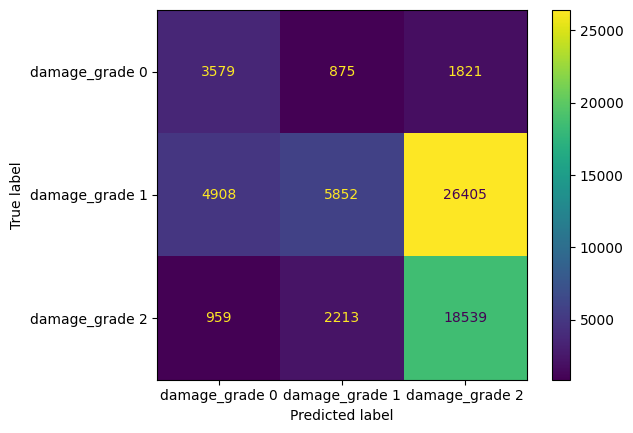

In [7]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot()

- So sánh Số liệu của kết quả 

In [8]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.38      0.57      0.46      6275
damage_grade 1       0.65      0.16      0.25     37165
damage_grade 2       0.40      0.85      0.54     21711

      accuracy                           0.43     65151
     macro avg       0.48      0.53      0.42     65151
  weighted avg       0.54      0.43      0.37     65151



## Bernouli Naive Bayes

In [9]:
bernNB = BernoulliNB()
bernNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB()

In [10]:
Y_pred = bernNB.predict(X_test)
Y_pred

array([0, 2, 1, ..., 2, 0, 0], dtype=int64)

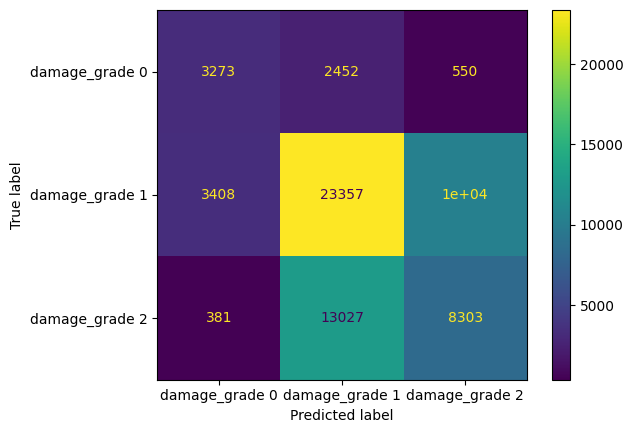

In [11]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot()

In [12]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.46      0.52      0.49      6275
damage_grade 1       0.60      0.63      0.61     37165
damage_grade 2       0.43      0.38      0.41     21711

      accuracy                           0.54     65151
     macro avg       0.50      0.51      0.50     65151
  weighted avg       0.53      0.54      0.53     65151



## Multinomial Naive Bayes

In [13]:
mulNB = MultinomialNB()
mulNB.fit(X_train, Y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

In [14]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_test = min_max_scaler.fit_transform(X_test)

In [15]:
Y_pred = mulNB.predict(X_test)
Y_pred

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

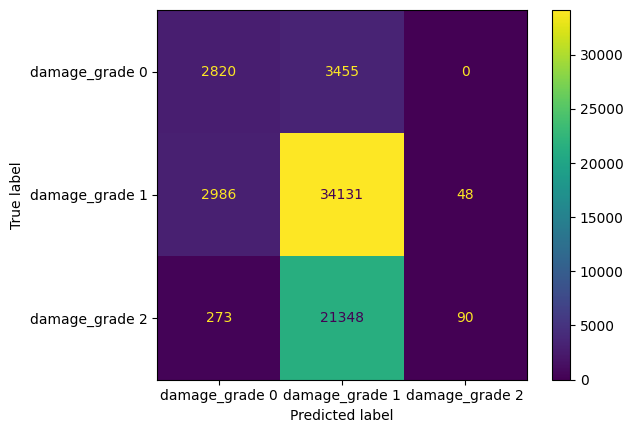

In [16]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
metrics.ConfusionMatrixDisplay(cm, display_labels=["damage_grade 0", "damage_grade 1", "damage_grade 2"]).plot()

In [17]:
print(metrics.classification_report(Y_test, Y_pred, target_names=["damage_grade 0", "damage_grade 1", "damage_grade 2"]))

                precision    recall  f1-score   support

damage_grade 0       0.46      0.45      0.46      6275
damage_grade 1       0.58      0.92      0.71     37165
damage_grade 2       0.65      0.00      0.01     21711

      accuracy                           0.57     65151
     macro avg       0.57      0.46      0.39     65151
  weighted avg       0.59      0.57      0.45     65151

